# Analysis of H Bridge Converter

## Problem Statement

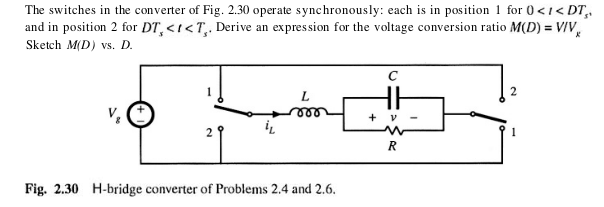

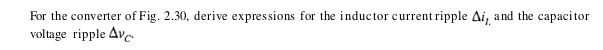

## Hand Analysis 

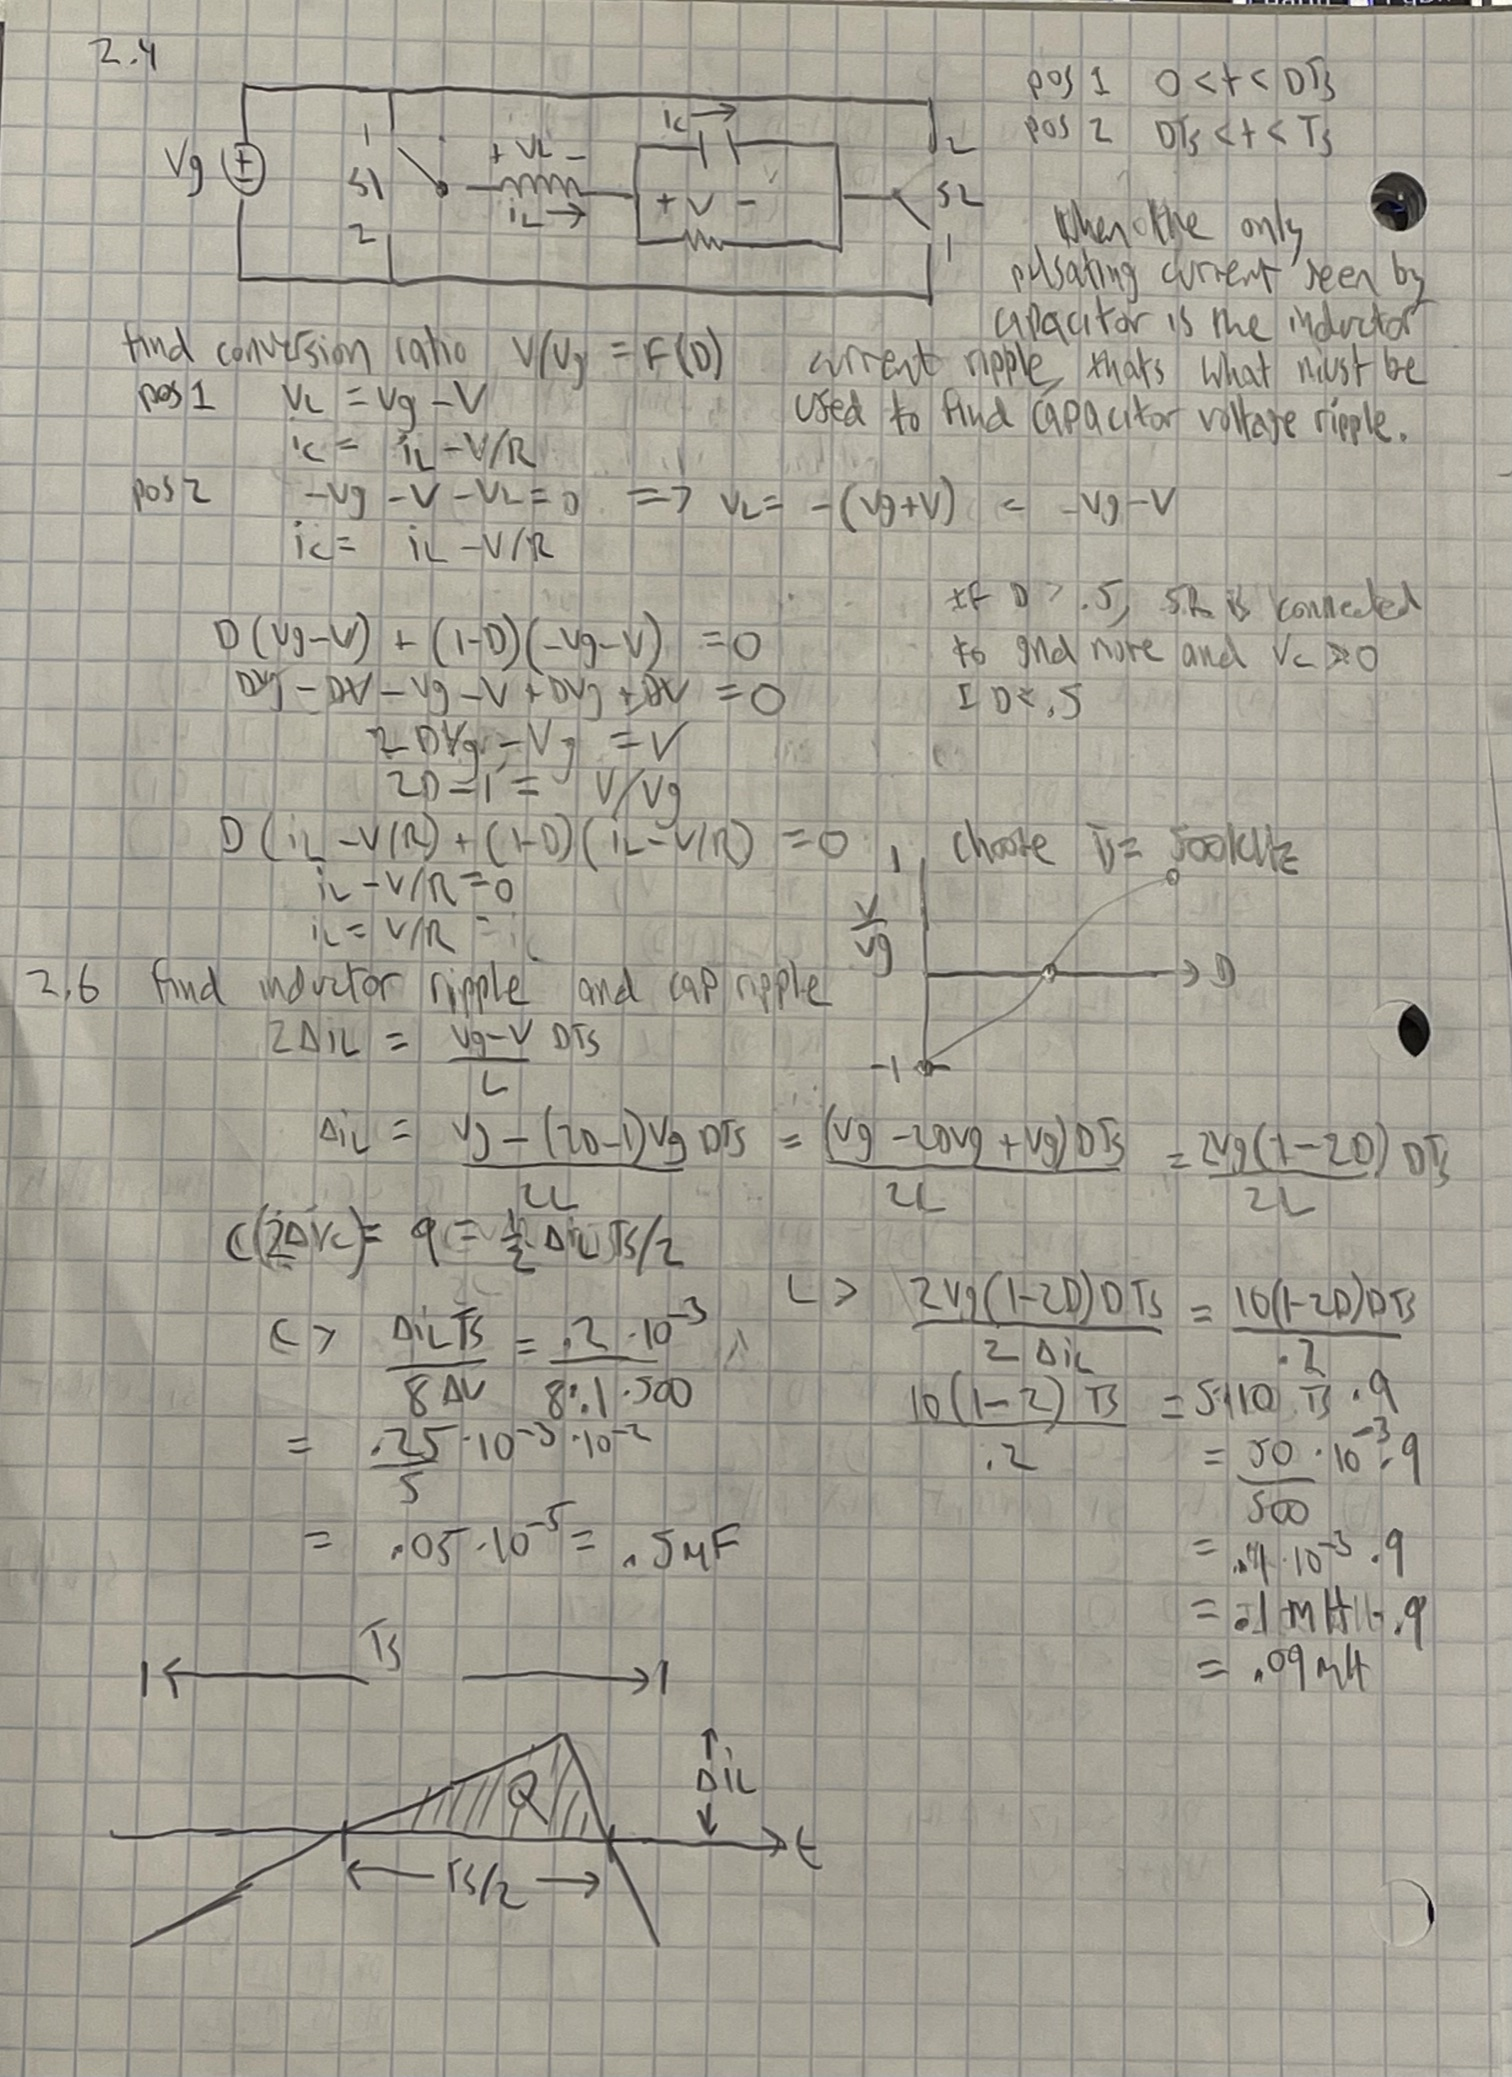

## Import what is needed

In [1]:
from IPython.display import display, Latex
from functools import wraps
from orderedset import OrderedSet
import sympy
from sympy.core.symbol import symbols, Symbol

from sympy.printing import latex, pprint
from sympy import Symbol, simplify
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter

from math import log10
from PyLTSpice import LTSpice_RawRead
from sympy.solvers import solve
import sys
import logging
from ipywidgets import FloatSlider, interact, interactive
from converter5 import *

Found Numpy. WIll be used for storing data


## Make the variables (which are subclass of Sympy Symbol)

In [2]:
def make_symbols():
    global R, C, L, D, s, Vc, Vg, VL, iin, iL, iC, iR, fs, M, delta_iL, delta_vC, Ts
    
    R = variable('R', 'ohms', None, real=True, positive=True)
    C = variable('C', 'F', None, real=True, positive=True)
    L = variable('L', 'H', real=True, positive=True)
    D = variable('D', '%', real=True, positive=True)
    
    fs = variable('f_s', 'Hz', real=True, positive=True)
    Ts = 1/fs

    Vc = variable('V_c', 'V', real=True)
    Vg = variable('V_g', 'V', real= True)
    VL = variable('V_L', 'V', real= True)

    iin = variable('i_in', 'A', real=True)
    iL = variable('i_L', 'A', real=True)
    iC = variable('i_C', 'A', real=True)
    iR = variable('i_R', 'A', real=True)
    delta_iL = variable('\Delta i_L', 'A', 'delta_iL', real=True)
    delta_vC = variable('\Delta v_C', 'V', 'detla_vC', real=True)
    M = variable('M', real=True)
    
    return
make_symbols()

## Set up logging, just in case

In [3]:
logformat = '{asctime}\n{message}'
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    #handlers somehow stay alive even after restarting iPython
    #console and clearing variables
    logger.handlers.clear()

logger.setLevel('DEBUG')
print(logger)
print(__name__)
# Use FileHandler() to log to a file
file_handler = logging.FileHandler('Problem2-4.log', mode='w')
formatter = logging.Formatter(fmt=logformat, style='{' )
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

<Logger __main__ (DEBUG)>
__main__


## Let's get started! 
### Create a converter, and the inductor volt-seconds equilibrium equation, and define M, the conversion ratio

In [4]:
hbridge = converter()
hbridge.equations.add(D*(Vg-Vc)+(1-D)*(-Vg-Vc)) #VLavg must equal 0 in steady state
hbridge.equations.add(M-Vc/Vg)

### Calling the solver method of the hbridge converter instance will find the wanted variable in every possible form (as it relates to all the other variables in accordance with the equations defining the converter). For each possible form, a function (hbridge.computesym()) is created that can be called, to calculate a number for the wanted variable, given some inputs. 
The myprint() function displays the equations. 

In [5]:
myprint(Vc, *hbridge.solver(given={}, want=Vc))
myprint(M, *hbridge.solver(given={}, want=M))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### See the LTSpice circuit below. The results of the simulation are plotted along with the solution from the equation solver. The results line up nicely. 

In [6]:
from PyLTSpice import LTSteps
log = os.path.join(os.getcwd(), 'problem2-4_2.log')
lr = LTSteps.LTSpiceLogReader(log)


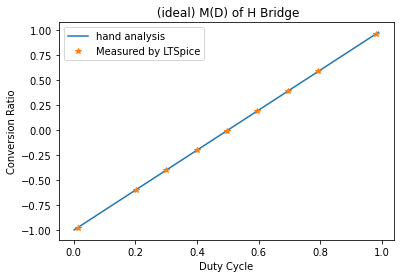

In [7]:
duty = np.linspace(.001, .99, 100)
fig, ax = plt.subplots(subplot_kw={'title':' (ideal) M(D) of H Bridge'})
M_ = hbridge.computesym(M, {D:duty})
ax.plot(duty, M_, label ='hand analysis')
ax.set_xlabel('Duty Cycle')
ax.set_ylabel('Conversion Ratio')
ax.plot(lr.get_measure_values_at_steps('d', None), lr.get_measure_values_at_steps('m', None),
        marker='*', linestyle='', label='Measured by LTSpice')
ax.legend()

### This is screen capture of the LTSpice waveform viewer, plotting the stepped measured data. 

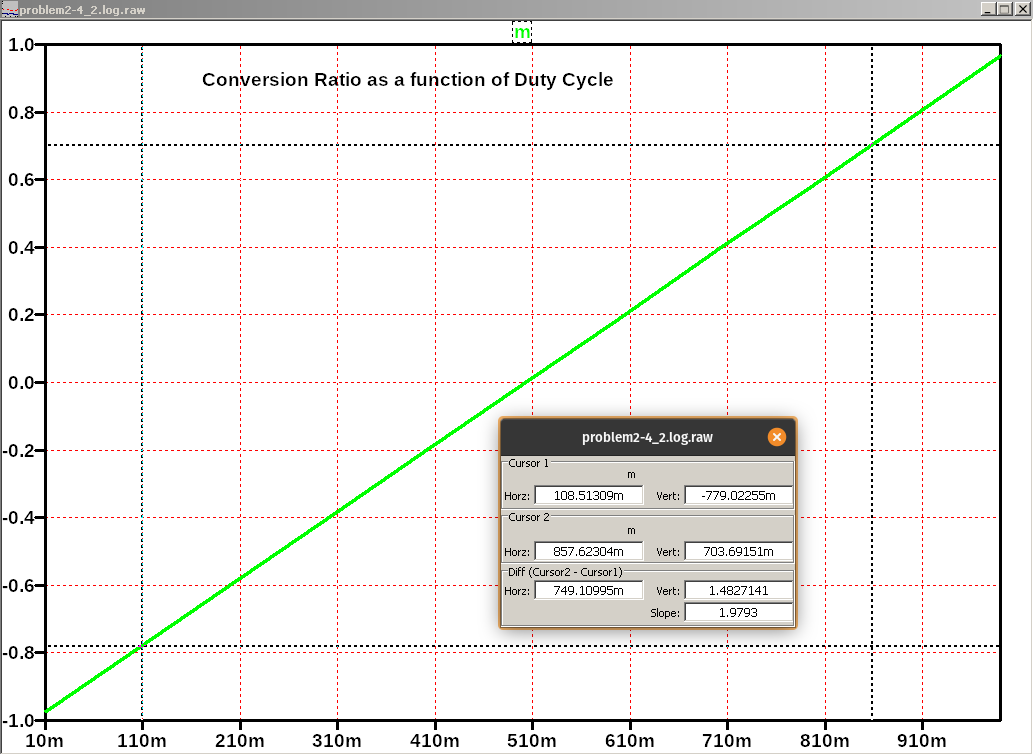

### Add some more equation to the converter, from hand analysis. They relate inductor current ripple and capacitor voltage ripple to other variables. 

In [8]:
hbridge.equations.add(2*delta_iL - (Vg-Vc)*D*Ts/L)
hbridge.equations.add(C*2*delta_vC - .5*delta_iL*Ts/2)
hbridge.equations.add(iL - Vc/R)
hbridge.showequations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### With more variables, solving for desired variables can be a real chore, on paper, but here it's easy. 

In [9]:
myprint(delta_iL, *hbridge.solver(given={}, want=delta_iL))
myprint(delta_vC, *hbridge.solver(given={}, want=delta_vC))
myprint(iL, *hbridge.solver(given={}, want=iL))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Find some actual numbers, given the inputs. The inputs are just example numbers, but they allow direct comparison to the simulation. And they match! 

In [10]:
given = {Vg:10, D:.6, L:.08e-3, C:.5e-6, R:10, fs:100e3}
hbridge.showresult(Vc, given)
hbridge.showresult(iL, given)
hbridge.showresult(delta_vC, given)
hbridge.showresult(delta_iL, given)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

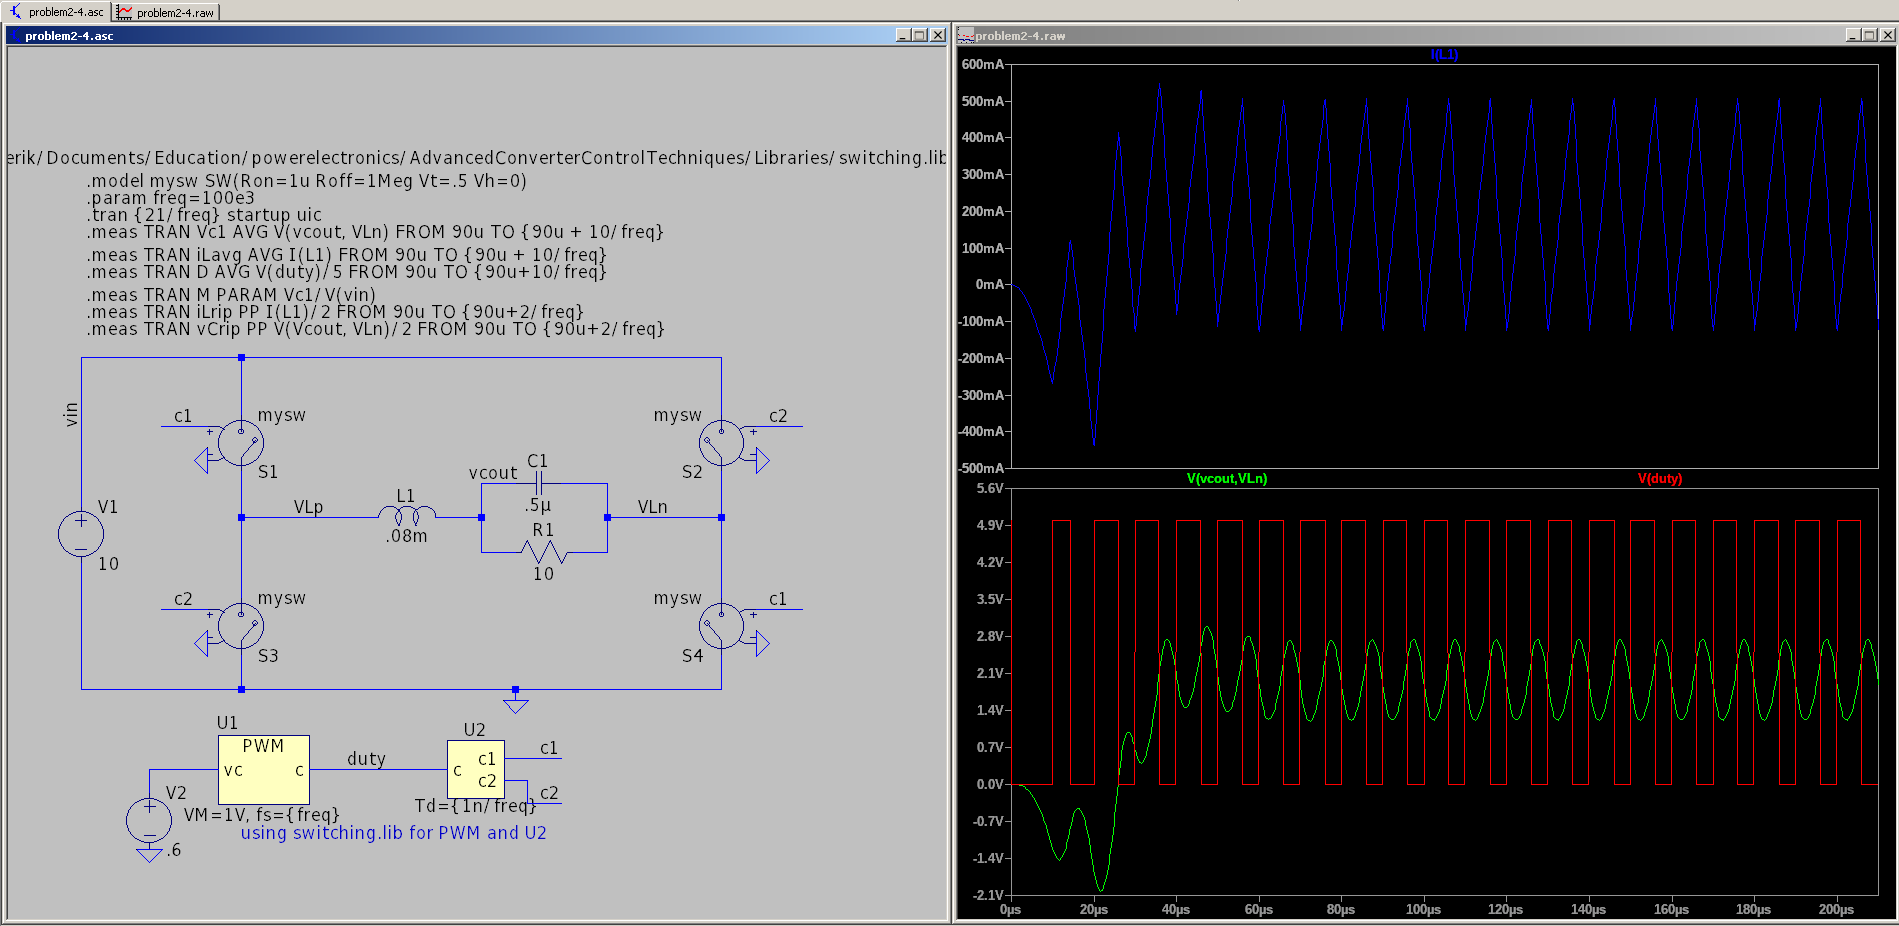

### The spice error log shows us the results of the measure statements in the simulation. 

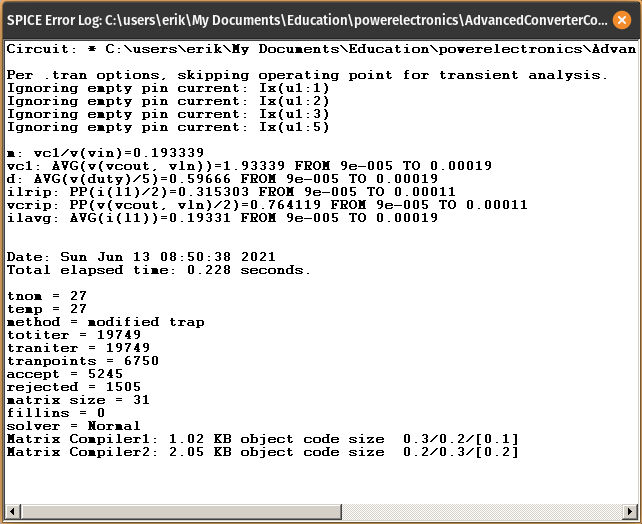

### Also plot the time domain simulation result. 

In [11]:
raw = os.path.join(os.getcwd(), 'problem2-4.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
Vc = LTR.get_trace("V(vcout)").get_wave() - LTR.get_trace("V(vln)").get_wave()

#iT = LTR.get_trace("I(S1)").get_wave()
iL = LTR.get_trace("I(L1)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()

Normal access


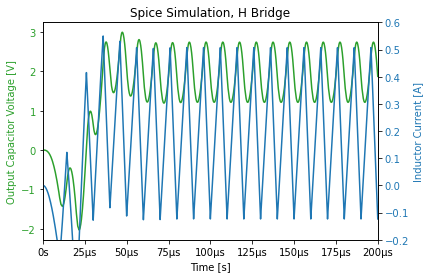

In [13]:
%matplotlib inline
period = 1/given[fs]
subplot_kw={'title':'Spice Simulation, H Bridge',
           'xlabel': 'Time [s]'}
      
#fig, (ax1, ax2) = plt.subplots(2,1)
fig, ax1 = plt.subplots(subplot_kw = subplot_kw)
ax1.set_xlim(left = 0, right=20*period)
major_formatter= EngFormatter(unit='s', places=0, sep='')
ax1.xaxis.set_major_formatter(major_formatter)

color = 'tab:green'
ax2 = ax1.twinx()
ax1.plot(t_sim, Vc, label='Vout', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Output Capacitor Voltage [V]', color=color)

color = 'tab:blue'
ax2.plot(t_sim, iL, label='iL', color=color)
ax2.set_ylim(-.2, .6)
ax2.set_ylabel('Inductor Current [A]', color=color)
ax2.tick_params(axis='y', labelcolor=color)